In [32]:
# Design specifications and material properties

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve

# Fuel assembly (FA) representative of average core conditions
P_FA = 6.641 #[MW] Fuel assembly thermal power
N_FP = 284 #[pin] Number of fuel pins in the fuel assembly
q_l0 = 26.03 #[kW/m] Linear heat rate at fuel midplane, q'(0)
pitch = 13.6 #[mm] Pin pitch
T_co_in = 400 #[°C] Coolant inlet temperature
T_co_out = 480 #[°C] Coolant outlet temperature

# Coolant properties (uniform along the channel) - Liquid Pb
cp_co = 146 #[J/kg-°C] Average heat capacity
rho_co = 10520 #[kg/m^3] Average density
mu_co = 0.002 #[Pa-s] Average dynamic viscosity
k_co = 15.5 #[W/m-°C] Average thermal conductivity

# Fuel pins
D_clad_ext = 8.50 #[mm] External diameter of cladding
t_clad = 0.600 #[mm] Cladding thickness
H_act = 1100 #[mm] Active length
H_tot = 2100 #[mm] Total length

# Fuel - solid pellets (MOX)
TD_fuel = 11.31 #[g/cm^3] Theoretical density of MOX fuel
rho_fuel = 0.88*TD_fuel #[g/cm^3] Density of fuel
T_fuel_melt = 2730 #[°C] Melting temperature of fresh fuel
D_fuel = 6.98 #[mm] Fuel pellet diameter
alpha_l_fuel = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_fuel = 170 #[GPa] Young's modulus of solid pellets
nu_poisson_fuel = 0.31 #[/] Poisson's coefficient

# Cladding - Ferritic-martensitic steel T91 (UNS No. K90901)
T_clad_melt = 1500 #[°C] Melting temperature of cladding
k_clad = 28.7 #[W/m-°C] Average thermal conductivity of cladding
alpha_l_clad = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_clad = 170 #[GPa] Young's modulus of cladding
nu_poisson_clad = 0.3 #[/] Poisson's coefficient
#SY_clad = 563.1 - 4.878e-1*T_clad + 1.6e-3*T_clad**2 - 3e-6*T_clad**3 + 8e-10*T_clad**4 #[MPa] Yield strength of cladding

In [33]:
# COLD GEOMETRY ANALYSIS
# (I)

# Coolant mass flowrate  (square channel 1/4*4 fuel pins = 1 fuel pin)
P_FP = P_FA/N_FP #[MW/pin] Average thermal power per fuel pin
m_co = P_FP/(cp_co*(T_co_out - T_co_in))*1e6 #[kg/s] Average coolant mass flowrate per channel
volflow_co = m_co/rho_co #[m^3/s] Average volumetric flow of coolant per channel
print('Average thermal power per fuel pin:',P_FP,'[MW/pin]')
print('Average coolant mass flowrate per channel:',m_co,'[kg/s]')

# Geometry of channel
A_channel = pitch**2-(np.pi*D_clad_ext**2/4) #[mm^2] Area channel
P_w = np.pi*D_clad_ext #[mm] Wet perimeter
D_h = 4*A_channel/P_w/1000 #[m] Hydraulic diameter of channel
print('Hydraulic diameter of channel:',D_h, '[m]')

# Calculation of velocity of coolant in channel
v_co = volflow_co/(A_channel/1e6) #[m/s] Average velocity of coolant in channel
print('Average velocity of coolant in channel',v_co,'[m/s]')

# Reynolds number of coolant
Re_co = rho_co*v_co*D_h/mu_co #[/]
print('Reynolds number of coolant:', Re_co)

# Darcy factor
f_darcy=0.184*Re_co**(-0.20)
print('Darcy factor of coolant per channel:', f_darcy)

# Calculation of Prandtl number
Pr_co = mu_co*cp_co/k_co #[/]
print('Prandtl number of coolant:', Pr_co)

# Calculation of Peclet number
Pe_co = Re_co*Pr_co #[/]
print('Peclet number of coolant:', Pe_co)

# Calculation of Nusselt number
x = pitch/D_clad_ext #[/] Pin-pitch to cladding outer diameter ratio
print('Pin-pitch to cladding outer diameter ratio:', x)
Nu_co_1 = 0.58*(D_h/(D_clad_ext/1000))**0.55*Pe_co**0.45 #discarded x value out of range
Nu_co = 4.5 + 0.014*Pe_co**0.8
print('Nusselt1 number of coolant:', Nu_co_1)
print('Nusselt number of coolant:', Nu_co)

# Heat transfer coefficient of coolant
h_co = Nu_co*k_co/D_h #[W/m^2-°C]
print('Heat transfer coefficient of coolant:', h_co, '[W/m^2-°C]')

# Pressure drops in subchannel
g=9.81
dp_g = rho_co*g*H_tot  # Gravitational pressure drops
dp_c = k_co*rho_co*(v_co^2)/2  # Concentrated pressure drops
dp_d = f_darcy*rho_co*(v_co^2)/2 *H_tot/D_h # Distributed pressure drops

dp = dp_d + dp_c + dp_g # Total pressure drops

Average thermal power per fuel pin: 0.02338380281690141 [MW/pin]
Average coolant mass flowrate per channel: 2.0020379124059424 [kg/s]
Hydraulic diameter of channel: 0.01920569249343714 [m]
Average velocity of coolant in channel 1.4842866438142674 [m/s]
Reynolds number of coolant: 149945.52000789868
Darcy factor of coolant per channel: 0.01696801830703975
Prandtl number of coolant: 0.018838709677419355
Peclet number of coolant: 2824.7801188584785
Pin-pitch to cladding outer diameter ratio: 1.5999999999999999
Nusselt1 number of coolant: 32.439724710137625
Nusselt number of coolant: 12.570784551614757
Heat transfer coefficient of coolant: 10145.281697945067 [W/m^2-°C]


In [34]:
# COLD GEOMETRY ANALYSIS
# (II)

# Average linear heat rate
q_l_av = P_FP*1000/(H_act/1000) #[kW/m]
print('Average linear heat rate', q_l_av, '[kW/m]')

# Axial linear heat rate distribution [kW]
def q_l(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Average power per half fuel pin
int_q_l = (P_FP*1000)/2 #[kW] Integral from z=0 to z=H_ext is equal to the half of average power of 1 fuel pin
print('Fuel power of half pin fuel:',int_q_l,'[kW]')

# Define a function for the integral and the target value
def integral_eq(H_ext):
    # Compute the integral of q_l from 0 to H_ext
    integral, _ = quad(q_l, 0, H_ext/2, args=(H_ext,))
    return integral - int_q_l  # Return the difference from the target value

# Use fsolve to solve for H_ext that satisfies the integral equation
H_ext_solution = fsolve(integral_eq, 1.0)  # Initial guess for H_ext

print(f"Calculated H_ext: {H_ext_solution[0]}", "[m]")

Average linear heat rate 21.25800256081946 [kW/m]
Fuel power of half pin fuel: 11.691901408450704 [kW]
Calculated H_ext: 1.4111099335875872 [m]


In [35]:
# Verification of extrapolated length
H_ext = H_ext_solution[0]
z = H_ext/2

a = np.cos(np.pi * z/H_ext) #a should be zero
print(f"Cos(***): {a}")

# Axial linear heat rate distribution [kW]
def q_l2(z):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Evaluate the function at different values of z
z1 = 0
z2 = H_ext/2

print(f"q_l2(z = {z1} [m]) = {q_l2(z1)} [kW/m]")  #corresponds to qo given
print(f"q_l2(z = {z2} [m]) = {q_l2(z2)} [kW/m]")  #should be 0 in the extrapolated border

# Calculate the integral from 0 to H_ext
result, error = quad(q_l2, 0, z2)

print('Average thermal power per fuel pin:',P_FP*1000,'[kW/pin]')
print("Integral result:", 2*result,'[kW/pin]')
print("Estimated error:", error)

Cos(***): 6.123233995736766e-17
q_l2(z = 0 [m]) = 26.03 [kW/m]
q_l2(z = 0.7055549667937936 [m]) = 1.5938778090902803e-15 [kW/m]
Average thermal power per fuel pin: 23.383802816901408 [kW/pin]
Integral result: 23.38380281690141 [kW/pin]
Estimated error: 1.298061814530927e-13


Outer cladding temperature: 536.0818284974699 [°C]
Inner cladding temperature: 556.4604462569225 [°C]


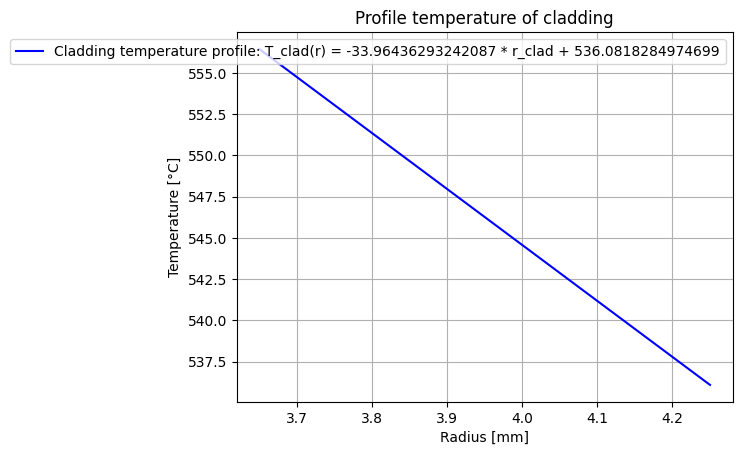

In [36]:
# Radial temperature profile at midplane of Cladding
# Assumption that the heat flux per area relative to a region (cladding, gap, fuel) is constant in that region, taking the value in the outer radius.

# Outer cladding temperature
T_co_avg0 = (T_co_in+T_co_out)/2 #[°C] Average temperature of coolant along the channel
T_clad_out = (q_l0*1e6/P_w)/h_co + T_co_avg0 #[°C] Outer cladding temperature
print('Outer cladding temperature:', T_clad_out, '[°C]')

# Define the constant value
dTdr_clad = -(q_l0*1e3)/(P_w*k_clad)  # Change this to your desired constant value

# Define the initial condition
r_clad_out = D_clad_ext/2 #[mm] External radius of cladding
T_clad_out = T_clad_out #[°C] Initial temperature of cladding at r_clad0

# Define the range of r values
r_clad_values = np.linspace(r_clad_out-t_clad, r_clad_out, 100)  #values along cladding thickness

# Solve the differential equation
C_clad = T_clad_out - dTdr_clad * r_clad_out  # Solve for constant C
T_clad_values = dTdr_clad * r_clad_values + C_clad  # Compute temperature values

# Inner cladding temperature
r_clad_in = r_clad_out - t_clad #[mm] Internal radius of cladding
T_clad_in = dTdr_clad * r_clad_in + C_clad
print('Inner cladding temperature:',T_clad_in, '[°C]')

# Plot the results
plt.plot(r_clad_values, T_clad_values, label=f'Cladding temperature profile: T_clad(r) = {dTdr_clad} * r_clad + {T_clad_out}', color='blue')
plt.title('Profile temperature of cladding')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.legend()
plt.show()

Outer temperature of He at cladding side: 556.4604462569225 [°C]
Solution for T_gap_in: 1892.7426275621442 [°C]
Average thermal conductivity of Helium in the gap: 0.5096294402370476 [W/m-K]


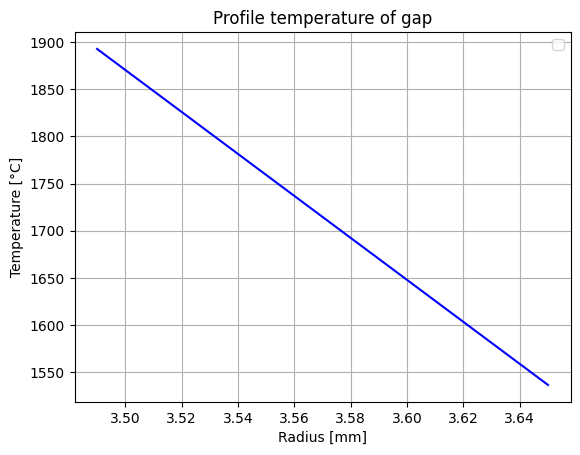

In [37]:
# Radial temperature profile at midplane of Gap

# Define constants
T_gap_out = T_clad_in #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel/2 #[mm] Inner radius of the gap
T_gap_out_K = T_gap_out + 273.15 #[K] Outer temperature of gap
print('Outer temperature of He at cladding side:',T_gap_out, '[°C]')

# Define the function that will solve for T_gap_in
def T_gap_profile(T_gap_in_K):
    # Define k_gap as a function of T_gap_in
    T_gap_avg = (T_gap_in_K + T_gap_out_K) / 2 #[K] Average temperature of the gap
    k_gap = 15.8e-4 * T_gap_avg**0.79 #[W/m-K] Thermal conductivity of Helium in the gap

    # Approximation of the integral of conductivity in the gap
    return (T_gap_in_K - T_gap_out_K) - (q_l0 * 1e3 * r_clad_out * (r_clad_out - r_clad_in)) / (P_w * r_clad_in * k_gap) #[K]

# Provide an initial guess for T_gap_in
T_gap_in_guess = T_gap_out_K + 5  #[K]

# Solve for T_gap_in using fsolve
T_gap_in_K_sol = fsolve(T_gap_profile, T_gap_in_guess)
T_gap_in = T_gap_in_K_sol[0] - 273.15 #[°C] Inner temperature of the gap at fuel side
print('Solution for T_gap_in:', T_gap_in,'[°C]')

# Define the range of r values
r_gap_values = np.linspace(r_gap_in, r_gap_out, 100)  #values along gap thickness

# Define the constant value
theta_gap = (T_gap_in_K_sol[0] + T_gap_out_K) / 2
k_gap_cte = 15.8e-4 * theta_gap**0.79 #[W/m-K] Average thermal conductivity of Helium in the gap
dTdr_gap = - (q_l0 * 1e3 * r_clad_out) / (P_w * r_clad_in * k_gap_cte) #[K/mm]
C_gap = T_gap_out_K - T_gap_in_K_sol - dTdr_gap * (r_gap_out - r_gap_in) # Constant of integration
T_gap_values = T_gap_out_K - dTdr_gap * (r_gap_out - r_gap_values) - C_gap - 273.15 #[°C] Compute temperature values of gap
print('Average thermal conductivity of Helium in the gap:', k_gap_cte,'[W/m-K]')

# Plot the results
plt.plot(r_gap_values, T_gap_values, color='blue')

plt.title('Profile temperature of gap')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.legend()
plt.show()

In [38]:
# HOT GEOMETRY ANALYSIS

# Radial temperature profile in fuel pin

theta_gas = (T_gas_fuel + T_gas_clad)/2 #[°C] Average temperature of Helium
k_gas = 15.8e-4*theta_gas**0.79 #[W/m-K] Thermal conductivity of Helium

# Verification of values

Q_clad_out = q_l0*H_act/1000

print('Total energy in outer radius of cladding:',Q_clad_out, [kW])

NameError: name 'T_gas_fuel' is not defined